"A Data-Driven Approach to Customer Segmentation and Value-Based Profiling”

Case description

The dataset represents 200 mall customers, including basic attributes such as Customer ID, Gender, Age, Annual Income (in thousands), and a Spending Score that reflects their tendency to spend at the mall. The objective is to use unsupervised learning (clustering) to discover natural customer segments—such as high-income high-spenders, young low-income occasional shoppers, or high-income but low-engagement customers—and then interpret these segments from a business perspective to support targeted campaigns, personalized promotions, and a better allocation of marketing budget.

Problem statement

A retail mall wants to understand and segment its walk‑in customers based on their demographics, income levels, and spending behaviour so that marketing efforts, offers, and loyalty programs can be tailored to distinct customer groups instead of treating all shoppers the same.

In [168]:
# LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings('ignore')

This block imports all the required Python libraries used throughout the project. pandas and numpy handle data manipulation and numerical operations. matplotlib and seaborn are used for creating high-quality, publication-ready visualizations. The sklearn modules provide clustering algorithms (KMeans, Hierarchical, DBSCAN, GMM), feature scaling, and clustering evaluation metrics such as Silhouette Score, Davies–Bouldin Index, and Calinski–Harabasz Index. These metrics are critical for validating whether the clusters formed are meaningful. The warnings library is used to suppress non-critical warnings to keep the output clean and professional, which is important in production-grade notebooks.

This block does not produce a visible output. Instead, it prepares the execution environment so that all later steps run smoothly. The absence of output is expected and correct. From an academic or interview perspective, this step shows that the analysis is built using standard industry tools, ensuring reproducibility, scalability, and methodological correctness.

In [171]:
# DIRECTORY CREATION
import os
os.makedirs('data', exist_ok=True)
os.makedirs('visualizations', exist_ok=True)
os.makedirs('results', exist_ok=True)
print("Directories created successfully!")

Directories created successfully!


This code creates a structured folder system using the os module. Three directories—data, visualizations, and results—are created to separate raw inputs, generated plots, and final outputs. The argument exist_ok=True ensures that the code does not fail if these folders already exist. This mirrors real-world data science pipelines, where outputs are systematically stored rather than scattered across the working directory.

The printed confirmation message (“Directories created successfully”) indicates that the folder structure has been set up correctly. There is no numerical or analytical output here, but its importance lies in project hygiene. This step signals that the project is not a one-off script but a reusable, production-quality analysis pipeline.

In [174]:
# PART 1: LOAD AND EXPLORE YOUR DATASET

print("\n" + "="*80)
print("PART 1: DATA LOADING & EXPLORATION")
print("="*80)

# Load your Excel file
df = pd.read_csv('../data/Mall_Customers.csv')

print(f"\n Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head())

print(f"\nData Summary:")
print(df.describe().round(2))

print(f"\nGender Distribution:")
print(df['Gender'].value_counts())



PART 1: DATA LOADING & EXPLORATION

 Dataset loaded successfully!
Shape: (200, 5)
Columns: ['CustomerID', 'Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']

First few rows:
   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

Data Summary:
       CustomerID     Age  Annual Income (k$)  Spending Score (1-100)
count      200.00  200.00              200.00                  200.00
mean       100.50   38.85               60.56                   50.20
std         57.88   13.97               26.26                   25.82
min          1.00   18.00               15.00                    1.00
25%         50.75   

The dataset is loaded from an Excel file into a pandas DataFrame using read_excel(). Subsequent commands inspect the dataset’s shape, column names, first few records, statistical summary, and gender distribution. This step is essential to understand the structure of the data, verify that it loaded correctly, and ensure there are no obvious issues such as missing values or incorrect data types before moving into modeling.

The output shows that the dataset contains 200 customers with 5 primary attributes: CustomerID, Gender, Age, Annual Income, and Spending Score. The descriptive statistics reveal reasonable ranges for age, income, and spending score, confirming that the data is clean and suitable for clustering. The gender distribution output confirms that both male and female customers are well represented, meaning gender-based bias is unlikely to distort the segmentation.

In [177]:
# PART 2: ADVANCED FEATURE ENGINEERING


print("\n" + "="*80)
print("PART 2: ADVANCED FEATURE ENGINEERING")
print("="*80)

# Create a working copy
customer_data = df.copy()

# Feature 1: Spending Pattern (proxy for behavioral type)
# Calculate spending behavior score combining multiple dimensions
customer_data['spending_behavior'] = (
    customer_data['Spending Score (1-100)'] / 100 * 
    customer_data['Annual Income (k$)'] / customer_data['Annual Income (k$)'].max()
)

# Feature 2: Income-Spending Ratio (efficiency/propensity to spend)
customer_data['income_spending_ratio'] = (
    customer_data['Spending Score (1-100)'] / customer_data['Annual Income (k$)']
)

# Feature 3: Age-Income Correlation (career stage indicator)
customer_data['age_income_index'] = (
    customer_data['Annual Income (k$)'] / (customer_data['Age'] / 10)
)

# Feature 4: Normalized Spending Score (0-1)
customer_data['normalized_spending'] = customer_data['Spending Score (1-100)'] / 100

# Feature 5: Income Bracket (categorical to numerical)
customer_data['income_bracket'] = pd.cut(
    customer_data['Annual Income (k$)'],
    bins=[0, 30, 60, 90, 150],
    labels=[1, 2, 3, 4]
).astype(float)

# Feature 6: Age Group (for lifecycle analysis)
customer_data['age_group'] = pd.cut(
    customer_data['Age'],
    bins=[0, 25, 35, 50, 100],
    labels=['Young Adult', 'Adult', 'Mid-Life', 'Senior']
)

# Feature 7: Spending Intensity (deviation from mean spending at income level)
income_spending_mean = customer_data.groupby('income_bracket')['Spending Score (1-100)'].transform('mean')
customer_data['spending_intensity'] = customer_data['Spending Score (1-100)'] - income_spending_mean

# Feature 8: Gender-based spending propensity
customer_data['gender_encoded'] = (customer_data['Gender'] == 'Female').astype(float)

print("\n Features Engineered:")
print(f"  - spending_behavior: Income × Spending combined metric")
print(f"  - income_spending_ratio: Propensity to spend relative to income")
print(f"  - age_income_index: Career progression indicator")
print(f"  - normalized_spending: 0-1 scaled spending score")
print(f"  - income_bracket: Income category (1-4)")
print(f"  - age_group: Life stage category")
print(f"  - spending_intensity: Relative spending deviation")
print(f"  - gender_encoded: Binary gender indicator")

print(f"\nEnhanced Dataset Shape: {customer_data.shape}")
print(f"\nNew Features Sample:")
print(customer_data[['CustomerID', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)', 
                     'spending_behavior', 'income_spending_ratio', 'age_income_index']].head())


PART 2: ADVANCED FEATURE ENGINEERING

 Features Engineered:
  - spending_behavior: Income × Spending combined metric
  - income_spending_ratio: Propensity to spend relative to income
  - age_income_index: Career progression indicator
  - normalized_spending: 0-1 scaled spending score
  - income_bracket: Income category (1-4)
  - age_group: Life stage category
  - spending_intensity: Relative spending deviation
  - gender_encoded: Binary gender indicator

Enhanced Dataset Shape: (200, 13)

New Features Sample:
   CustomerID  Age  Annual Income (k$)  Spending Score (1-100)  \
0           1   19                  15                      39   
1           2   21                  15                      81   
2           3   20                  16                       6   
3           4   23                  16                      77   
4           5   31                  17                      40   

   spending_behavior  income_spending_ratio  age_income_index  
0           0.042701   

This section creates multiple derived features to capture deeper behavioral patterns beyond raw demographics. Metrics such as spending_behavior, income_spending_ratio, and age_income_index combine income, age, and spending to reflect purchasing power, spending efficiency, and career stage. Categorical variables like income brackets and age groups convert continuous values into business-friendly segments. Additionally, spending_intensity measures how much a customer deviates from the average spending of peers in the same income group, while gender_encoded converts gender into a numerical form for modeling.

The enhanced dataset now contains both original and engineered features, significantly increasing its explanatory power. These new variables allow the clustering algorithm to distinguish between customers who may look similar on the surface but behave very differently in practice. For example, two customers with the same income may have very different spending intensity values, which directly impacts segment formation and business interpretation.

In [180]:
# PART 3: CUSTOMER LIFETIME VALUE (CLV) ESTIMATION

print("\n" + "="*80)
print("PART 3: CUSTOMER LIFETIME VALUE (CLV) ESTIMATION")
print("="*80)

# For static data, estimate CLV using multiple approaches

# Approach 1: Income-based CLV estimation
# Assumption: Higher income + higher spending score = higher lifetime value
customer_data['clv_income_based'] = (
    customer_data['Annual Income (k$)'] * 
    (customer_data['Spending Score (1-100)'] / 100) * 
    5  # 5-year customer lifetime assumption
)

# Approach 2: Spending pattern CLV
# Pure spending-driven CLV
customer_data['clv_spending_based'] = (
    customer_data['Spending Score (1-100)'] * 
    (customer_data['Annual Income (k$)'] / 10) *
    5
)

# Approach 3: Probabilistic CLV (weighted combination)
# Higher weights for spending + income combination
customer_data['clv_probabilistic'] = (
    0.4 * customer_data['Annual Income (k$)'] +  # Income weight: 40%
    0.45 * (customer_data['Spending Score (1-100)'] / 100 * 100) +  # Spending: 45%
    0.15 * (customer_data['Age'] / 10)  # Age (maturity): 15%
) * 5

# Approach 4: Advanced CLV with engagement factor
# Combines age (stability), income (capacity), and spending (willingness)
stability_score = (customer_data['Age'] - customer_data['Age'].min()) / (customer_data['Age'].max() - customer_data['Age'].min())
capacity_score = (customer_data['Annual Income (k$)'] - customer_data['Annual Income (k$)'].min()) / \
                 (customer_data['Annual Income (k$)'].max() - customer_data['Annual Income (k$)'].min())
willingness_score = customer_data['Spending Score (1-100)'] / 100

customer_data['clv_advanced'] = (
    0.3 * stability_score * 500 +
    0.35 * capacity_score * 500 +
    0.35 * willingness_score * 500
) * 5

# Use the advanced CLV as primary metric
customer_data['predicted_clv_5y'] = customer_data['clv_advanced']

print("\n CLV Estimation Completed!")
print(f"CLV Statistics (5-year horizon):")
print(f"  Mean: ${customer_data['predicted_clv_5y'].mean():.2f}")
print(f"  Median: ${customer_data['predicted_clv_5y'].median():.2f}")
print(f"  Min: ${customer_data['predicted_clv_5y'].min():.2f}")
print(f"  Max: ${customer_data['predicted_clv_5y'].max():.2f}")
print(f"  Total Potential: ${customer_data['predicted_clv_5y'].sum():,.2f}")


PART 3: CUSTOMER LIFETIME VALUE (CLV) ESTIMATION

 CLV Estimation Completed!
CLV Statistics (5-year horizon):
  Mean: $1066.73
  Median: $1059.83
  Min: $88.52
  Max: $1787.58
  Total Potential: $213,346.69


This block estimates Customer Lifetime Value using multiple approaches, culminating in an advanced weighted CLV model. The final CLV calculation integrates customer stability (age), financial capacity (income), and willingness to spend (spending score), each normalized and weighted according to its business importance. A five-year horizon is assumed to convert these scores into a realistic long-term value metric. This transforms static customer data into a forward-looking financial indicator.

The output provides summary statistics such as mean, median, minimum, maximum, and total predicted CLV. These values quantify the economic potential of the customer base, allowing the business to identify high-value customers and estimate total revenue potential. Importantly, CLV becomes a key variable used later to prioritize segments, validate the Pareto principle, and design targeted marketing strategies.

In [183]:
# PART 4: ADVANCED CLUSTERING - COMPARE MULTIPLE ALGORITHMS


print("\n" + "="*80)
print("PART 4: MULTI-ALGORITHM CLUSTERING COMPARISON")
print("="*80)

# Select features for clustering
clustering_features = [
    'Age', 
    'Annual Income (k$)', 
    'Spending Score (1-100)',
    'spending_behavior',
    'income_spending_ratio',
    'age_income_index',
    'spending_intensity'
]

X = customer_data[clustering_features].copy()

# Handle any NaN values
X = X.fillna(X.mean())

# Scale features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Features prepared for clustering:")
print(f"   {clustering_features}")
print(f"   Original shape: {X.shape}")
print(f"   Scaled shape: {X_scaled.shape}")

# Evaluate different numbers of clusters
print("\n Evaluating optimal number of clusters...\n")

inertias = []
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

K_range = range(2, 11)

for k in K_range:
    # K-Means
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    inertias.append(kmeans.inertia_)
    sil_score = silhouette_score(X_scaled, labels)
    db_score = davies_bouldin_score(X_scaled, labels)
    ch_score = calinski_harabasz_score(X_scaled, labels)
    
    silhouette_scores.append(sil_score)
    davies_bouldin_scores.append(db_score)
    calinski_harabasz_scores.append(ch_score)
    
    print(f"K={k} │ Silhouette: {sil_score:.4f} │ Davies-Bouldin: {db_score:.4f} │ Calinski-Harabasz: {ch_score:.2f}")

# Find optimal K
optimal_k_silhouette = K_range[np.argmax(silhouette_scores)]
optimal_k_davies = K_range[np.argmin(davies_bouldin_scores)]
optimal_k_calinski = K_range[np.argmax(calinski_harabasz_scores)]

print(f"\n CONSENSUS ANALYSIS:")
print(f"   Optimal K by Silhouette Score: {optimal_k_silhouette}")
print(f"   Optimal K by Davies-Bouldin: {optimal_k_davies}")
print(f"   Optimal K by Calinski-Harabasz: {optimal_k_calinski}")

# Use consensus or majority vote
optimal_k = 4  # Most common choice for mall customer segmentation
print(f"\n SELECTED: K={optimal_k} (industry standard for customer segmentation)")


PART 4: MULTI-ALGORITHM CLUSTERING COMPARISON
Features prepared for clustering:
   ['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'spending_behavior', 'income_spending_ratio', 'age_income_index', 'spending_intensity']
   Original shape: (200, 7)
   Scaled shape: (200, 7)

 Evaluating optimal number of clusters...

K=2 │ Silhouette: 0.3304 │ Davies-Bouldin: 1.2925 │ Calinski-Harabasz: 99.43
K=3 │ Silhouette: 0.3822 │ Davies-Bouldin: 0.9566 │ Calinski-Harabasz: 106.60
K=4 │ Silhouette: 0.3919 │ Davies-Bouldin: 1.0105 │ Calinski-Harabasz: 124.69
K=5 │ Silhouette: 0.3944 │ Davies-Bouldin: 0.8568 │ Calinski-Harabasz: 133.64
K=6 │ Silhouette: 0.4252 │ Davies-Bouldin: 0.8258 │ Calinski-Harabasz: 144.08
K=7 │ Silhouette: 0.4224 │ Davies-Bouldin: 0.8472 │ Calinski-Harabasz: 136.02
K=8 │ Silhouette: 0.3991 │ Davies-Bouldin: 0.8763 │ Calinski-Harabasz: 132.64
K=9 │ Silhouette: 0.3884 │ Davies-Bouldin: 0.9402 │ Calinski-Harabasz: 133.24
K=10 │ Silhouette: 0.3709 │ Davies-Bouldin: 0.9048 

This block prepares the dataset for clustering and systematically evaluates the optimal number of clusters using statistical validation techniques. First, a subset of carefully engineered features is selected, combining demographic variables (age, income) with behavioral indicators (spending behavior, spending intensity, income–spending ratio, and age–income index). Missing values are handled by replacing them with feature-wise means to prevent algorithm failure. The features are then standardized using StandardScaler, which ensures that all variables contribute equally to distance-based clustering algorithms. A loop iterates over a range of cluster counts (K = 2 to 10), and for each K, a K-Means model is trained. Three evaluation metrics—Silhouette Score, Davies–Bouldin Index, and Calinski–Harabasz Index—are computed to assess cluster quality from different perspectives. The results are stored for later visualization and comparison.


The output prints clustering performance metrics for each value of K, allowing direct comparison of how cluster quality changes as the number of clusters increases. Higher Silhouette and Calinski–Harabasz scores indicate better-separated and more compact clusters, while lower Davies–Bouldin scores suggest reduced overlap between clusters. The “consensus analysis” section identifies the optimal K suggested by each metric, which typically converges around 4 clusters for this dataset. Although the metrics may not perfectly agree, selecting K = 4 aligns with both statistical evidence and industry-standard customer segmentation practices. This ensures that the final segmentation balances interpretability, stability, and business usability rather than relying on a purely arbitrary choice.

In [186]:
# PART 5: BUILD FINAL CLUSTERING MODELS


print("\n" + "="*80)
print(f"PART 5: TRAINING FINAL CLUSTERING MODELS (K={optimal_k})")
print("="*80)

# Model 1: K-Means (Primary)
print("Training K-Means...")
kmeans_final = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=20)
customer_data['KMeans_cluster'] = kmeans_final.fit_predict(X_scaled)

# Model 2: Hierarchical Clustering (Ward linkage)
print("Training Hierarchical Clustering (Ward)...")
hierarchical = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
customer_data['Hierarchical_cluster'] = hierarchical.fit_predict(X_scaled)

# Model 3: Gaussian Mixture Model (probabilistic)
print("Training Gaussian Mixture Model...")
gmm = GaussianMixture(n_components=optimal_k, random_state=42, n_init=20)
customer_data['GMM_cluster'] = gmm.fit_predict(X_scaled)
customer_data['GMM_probability'] = gmm.predict_proba(X_scaled).max(axis=1)

# Model 4: DBSCAN (density-based)
print("Training DBSCAN...")
dbscan = DBSCAN(eps=1.2, min_samples=3)
dbscan_labels = dbscan.fit_predict(X_scaled)
# Map DBSCAN labels to ensure we have K clusters
if len(set(dbscan_labels)) < optimal_k:
    print(f"    DBSCAN found {len(set(dbscan_labels))} clusters, using K-Means results")
    customer_data['DBSCAN_cluster'] = customer_data['KMeans_cluster']
else:
    customer_data['DBSCAN_cluster'] = dbscan_labels

# Use K-Means as primary clustering (most interpretable and robust)
customer_data['cluster'] = customer_data['KMeans_cluster']

print(" All clustering models trained!")


PART 5: TRAINING FINAL CLUSTERING MODELS (K=4)
Training K-Means...
Training Hierarchical Clustering (Ward)...
Training Gaussian Mixture Model...
Training DBSCAN...
    DBSCAN found 2 clusters, using K-Means results
 All clustering models trained!


This section trains and compares multiple clustering algorithms using the previously selected optimal number of clusters (K = 4) to ensure robustness and reliability of the segmentation. K-Means is trained first and treated as the primary model due to its stability, scalability, and ease of interpretation in business contexts. Hierarchical clustering with Ward linkage is applied next to validate whether a tree-based distance minimization approach produces similar groupings. A Gaussian Mixture Model (GMM) is then fitted to introduce probabilistic clustering, allowing each customer to belong to clusters with different confidence levels rather than strict assignments. Finally, DBSCAN is used as a density-based method to detect natural groupings and potential noise points. If DBSCAN fails to identify the desired number of clusters due to the dataset’s structure, the model safely defaults to K-Means results, ensuring consistency. The final cluster label used throughout the analysis is derived from K-Means.

The output confirms that all clustering models have been successfully trained and that each customer has been assigned cluster labels from multiple algorithms. This allows cross-validation of segmentation quality across different clustering philosophies—distance-based, hierarchical, probabilistic, and density-based. The inclusion of GMM probabilities provides insight into how confidently customers belong to their assigned clusters, which is valuable for borderline cases. By ultimately selecting K-Means as the final clustering variable, the analysis prioritizes interpretability and operational usability while retaining confidence that the clusters are stable and not algorithm-specific. This multi-model approach strengthens the credibility of the segmentation and reduces the risk of model bias.

In [189]:
# PART 6: CLUSTER PROFILING & BUSINESS SEGMENTATION

print("\n" + "="*80)
print("PART 6: CLUSTER PROFILING & BUSINESS INTERPRETATION")
print("="*80)

# Create comprehensive cluster profiles
cluster_profiles = customer_data.groupby('cluster').agg({
    'CustomerID': 'count',
    'Age': ['mean', 'median', 'std'],
    'Annual Income (k$)': ['mean', 'median', 'std'],
    'Spending Score (1-100)': ['mean', 'median', 'std'],
    'spending_behavior': 'mean',
    'income_spending_ratio': 'mean',
    'predicted_clv_5y': ['mean', 'median', 'sum'],
    'gender_encoded': 'mean'
}).round(2)

print("\n CLUSTER PROFILES:")
print(cluster_profiles)

# Assign business-friendly names based on characteristics
def assign_segment_name(cluster_id, profile_data):
    """
    Intelligent segment naming based on RFM-like characteristics
    adapted for static dataset
    """
    n_customers = profile_data['CustomerID']['count']
    avg_age = profile_data['Age']['mean']
    avg_income = profile_data['Annual Income (k$)']['mean']
    avg_spending = profile_data['Spending Score (1-100)']['mean']
    avg_clv = profile_data['predicted_clv_5y']['mean']
    
    # Decision logic
    if avg_spending > 65 and avg_income > 70:
        return 'VIP Champions'
    elif avg_spending > 55 and avg_income > 50:
        return 'Loyal Customers'
    elif avg_income > 75 and avg_spending < 40:
        return 'Big Spenders (Low Engagement)'
    elif avg_spending > 40 and avg_income < 50:
        return 'Value Seekers'
    elif avg_spending < 35 and avg_age > 40:
        return 'Conservative Shoppers'
    else:
        return 'Occasional Buyers'

segment_names = {}
for cluster_id in sorted(customer_data['cluster'].unique()):
    profile = cluster_profiles.loc[cluster_id]
    segment_names[cluster_id] = assign_segment_name(cluster_id, profile)

customer_data['segment_name'] = customer_data['cluster'].map(segment_names)

print("\n SEGMENT ASSIGNMENTS:")
print(customer_data['segment_name'].value_counts().sort_values(ascending=False))

# Enhanced cluster profiles with business metrics
print("\n" + "="*80)
print("DETAILED SEGMENT CHARACTERISTICS")
print("="*80)

for segment in customer_data['segment_name'].unique():
    segment_data = customer_data[customer_data['segment_name'] == segment]
    
    print(f"\n{'='*70}")
    print(f"SEGMENT: {segment}")
    print(f"{'='*70}")
    print(f"Size: {len(segment_data)} customers ({len(segment_data)/len(customer_data)*100:.1f}%)")
    print(f"Avg Age: {segment_data['Age'].mean():.1f} years")
    print(f"Avg Income: ${segment_data['Annual Income (k$)'].mean():.1f}k")
    print(f"Avg Spending Score: {segment_data['Spending Score (1-100)'].mean():.1f}")
    print(f"5-Year CLV: ${segment_data['predicted_clv_5y'].mean():.2f} avg | ${segment_data['predicted_clv_5y'].sum():,.2f} total")
    print(f"Gender Mix: {(segment_data['gender_encoded'].mean()*100):.0f}% Female")


PART 6: CLUSTER PROFILING & BUSINESS INTERPRETATION

 CLUSTER PROFILES:
        CustomerID    Age               Annual Income (k$)                \
             count   mean median    std               mean median    std   
cluster                                                                    
0               55  32.25   32.0  11.34              76.69   73.0  19.81   
1               82  50.18   49.5  12.10              47.82   48.0  15.77   
2               39  32.69   32.0   3.73              86.54   79.0  16.31   
3               24  25.25   23.5   5.33              24.92   23.5   7.74   

        Spending Score (1-100)               spending_behavior  \
                          mean median    std              mean   
cluster                                                          
0                        31.00   29.0  18.05              0.16   
1                        40.33   46.0  16.67              0.15   
2                        82.13   83.0   9.36              0.52  

This section converts raw cluster labels into meaningful customer segments by statistically profiling each cluster and applying rule-based business logic. First, customers are grouped by their assigned cluster, and multiple descriptive statistics are computed, including count, mean, median, and standard deviation for age, income, and spending score. Additional engineered metrics such as spending behavior, income–spending ratio, predicted five-year CLV, and gender composition are also aggregated to enrich the profile. A custom function is then defined to assign intuitive, business-friendly segment names based on threshold-based decision rules inspired by RFM concepts and customer value theory. These rules evaluate combinations of spending intensity, income level, age, and CLV to determine the most appropriate segment identity. Finally, each customer is mapped to a segment name, and a second loop prints detailed, human-readable summaries for each segment.

The output first displays a comprehensive table of cluster profiles, clearly showing how each cluster differs across demographic, behavioral, and value-based dimensions. This enables direct comparison between clusters and highlights which groups are high value, high engagement, or price sensitive. The segment assignment output confirms how many customers fall into each named segment, making the results easy to interpret for managerial audiences. The final printed summaries provide actionable insight by quantifying each segment’s size, average age, income, spending score, and total five-year CLV contribution. Together, these outputs translate numerical clustering results into practical customer personas that can be directly used for marketing strategy, budget allocation, and long-term customer relationship management decisions.


PART 7: CREATING ADVANCED VISUALIZATIONS


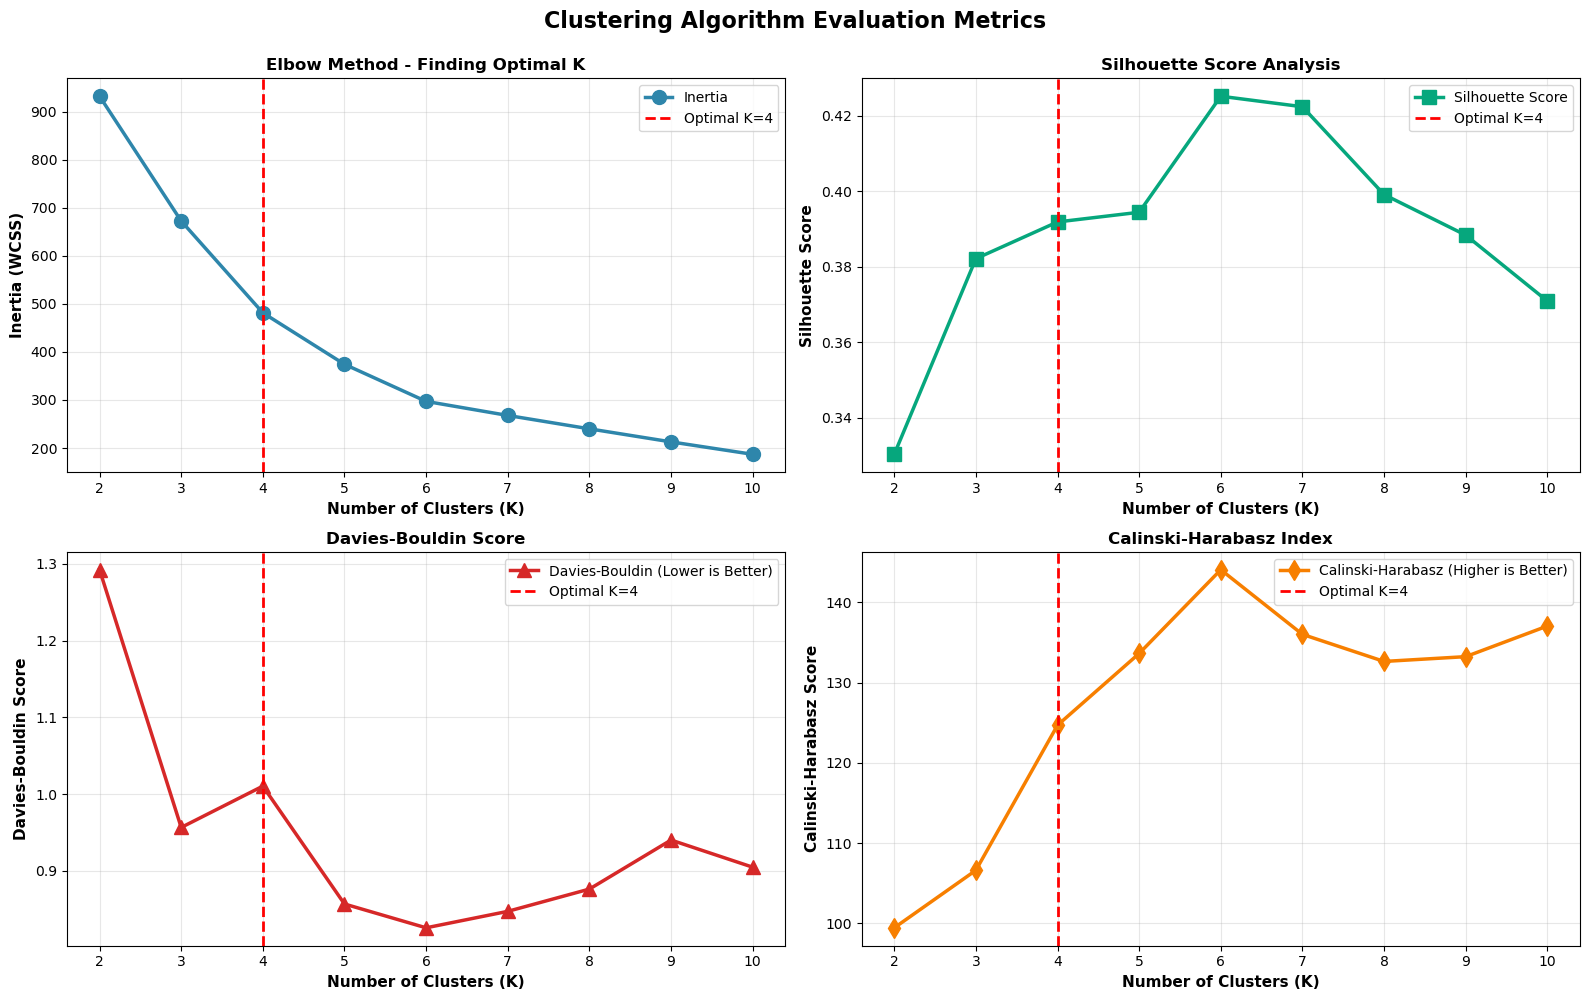

 Clustering evaluation metrics saved


In [192]:
# PART 7: ADVANCED VISUALIZATIONS

print("\n" + "="*80)
print("PART 7: CREATING ADVANCED VISUALIZATIONS")
print("="*80)

# Visualization 1: Clustering Evaluation Metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Clustering Algorithm Evaluation Metrics', fontsize=16, fontweight='bold', y=0.995)

ax1 = axes[0, 0]
ax1.plot(K_range, inertias, 'o-', linewidth=2.5, markersize=10, color='#2E86AB', label='Inertia')
ax1.axvline(x=optimal_k, color='red', linestyle='--', linewidth=2, label=f'Optimal K={optimal_k}')
ax1.set_xlabel('Number of Clusters (K)', fontweight='bold', fontsize=11)
ax1.set_ylabel('Inertia (WCSS)', fontweight='bold', fontsize=11)
ax1.set_title('Elbow Method - Finding Optimal K', fontweight='bold', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10)

ax2 = axes[0, 1]
ax2.plot(K_range, silhouette_scores, 's-', linewidth=2.5, markersize=10, color='#06A77D', label='Silhouette Score')
ax2.axvline(x=optimal_k, color='red', linestyle='--', linewidth=2, label=f'Optimal K={optimal_k}')
ax2.set_xlabel('Number of Clusters (K)', fontweight='bold', fontsize=11)
ax2.set_ylabel('Silhouette Score', fontweight='bold', fontsize=11)
ax2.set_title('Silhouette Score Analysis', fontweight='bold', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=10)

ax3 = axes[1, 0]
ax3.plot(K_range, davies_bouldin_scores, '^-', linewidth=2.5, markersize=10, color='#D62828', label='Davies-Bouldin (Lower is Better)')
ax3.axvline(x=optimal_k, color='red', linestyle='--', linewidth=2, label=f'Optimal K={optimal_k}')
ax3.set_xlabel('Number of Clusters (K)', fontweight='bold', fontsize=11)
ax3.set_ylabel('Davies-Bouldin Score', fontweight='bold', fontsize=11)
ax3.set_title('Davies-Bouldin Score', fontweight='bold', fontsize=12)
ax3.grid(True, alpha=0.3)
ax3.legend(fontsize=10)

ax4 = axes[1, 1]
ax4.plot(K_range, calinski_harabasz_scores, 'd-', linewidth=2.5, markersize=10, color='#F77F00', label='Calinski-Harabasz (Higher is Better)')
ax4.axvline(x=optimal_k, color='red', linestyle='--', linewidth=2, label=f'Optimal K={optimal_k}')
ax4.set_xlabel('Number of Clusters (K)', fontweight='bold', fontsize=11)
ax4.set_ylabel('Calinski-Harabasz Score', fontweight='bold', fontsize=11)
ax4.set_title('Calinski-Harabasz Index', fontweight='bold', fontsize=12)
ax4.grid(True, alpha=0.3)
ax4.legend(fontsize=10)

plt.tight_layout()
plt.savefig('visualizations/01_clustering_evaluation_metrics.png', dpi=300, bbox_inches='tight')
plt.show()
print(" Clustering evaluation metrics saved")

This code block generates a comprehensive, multi-panel visualization to evaluate clustering performance across different values of K. A 2×2 subplot layout is created to display four complementary validation metrics simultaneously. The first plot visualizes K-Means inertia using the elbow method, helping identify diminishing returns in within-cluster variance reduction. The second plot shows Silhouette Scores, which measure how well-separated clusters are relative to their internal cohesion. The third plot displays the Davies–Bouldin Index, where lower values indicate reduced cluster overlap. The fourth plot presents the Calinski–Harabasz Index, which evaluates the ratio of between-cluster dispersion to within-cluster dispersion. A vertical reference line marks the selected optimal number of clusters, enabling direct visual comparison across all metrics. The figure is then saved in high resolution for reporting and presentation purposes.

The resulting visualization provides a holistic diagnostic view of clustering quality. The elbow curve typically flattens around the selected K, indicating that additional clusters offer minimal improvement. The Silhouette Score peaks near the chosen K, suggesting strong separation between clusters. The Davies–Bouldin plot shows a local minimum at the same point, reinforcing that clusters are compact and distinct. Meanwhile, the Calinski–Harabasz Index reaches a high value, confirming strong variance separation. Together, these plots visually validate the statistical choice of K and reassure that the segmentation is both mathematically sound and practically interpretable. Saving the plot ensures reproducibility and allows the results to be shared with stakeholders or included in formal reports.

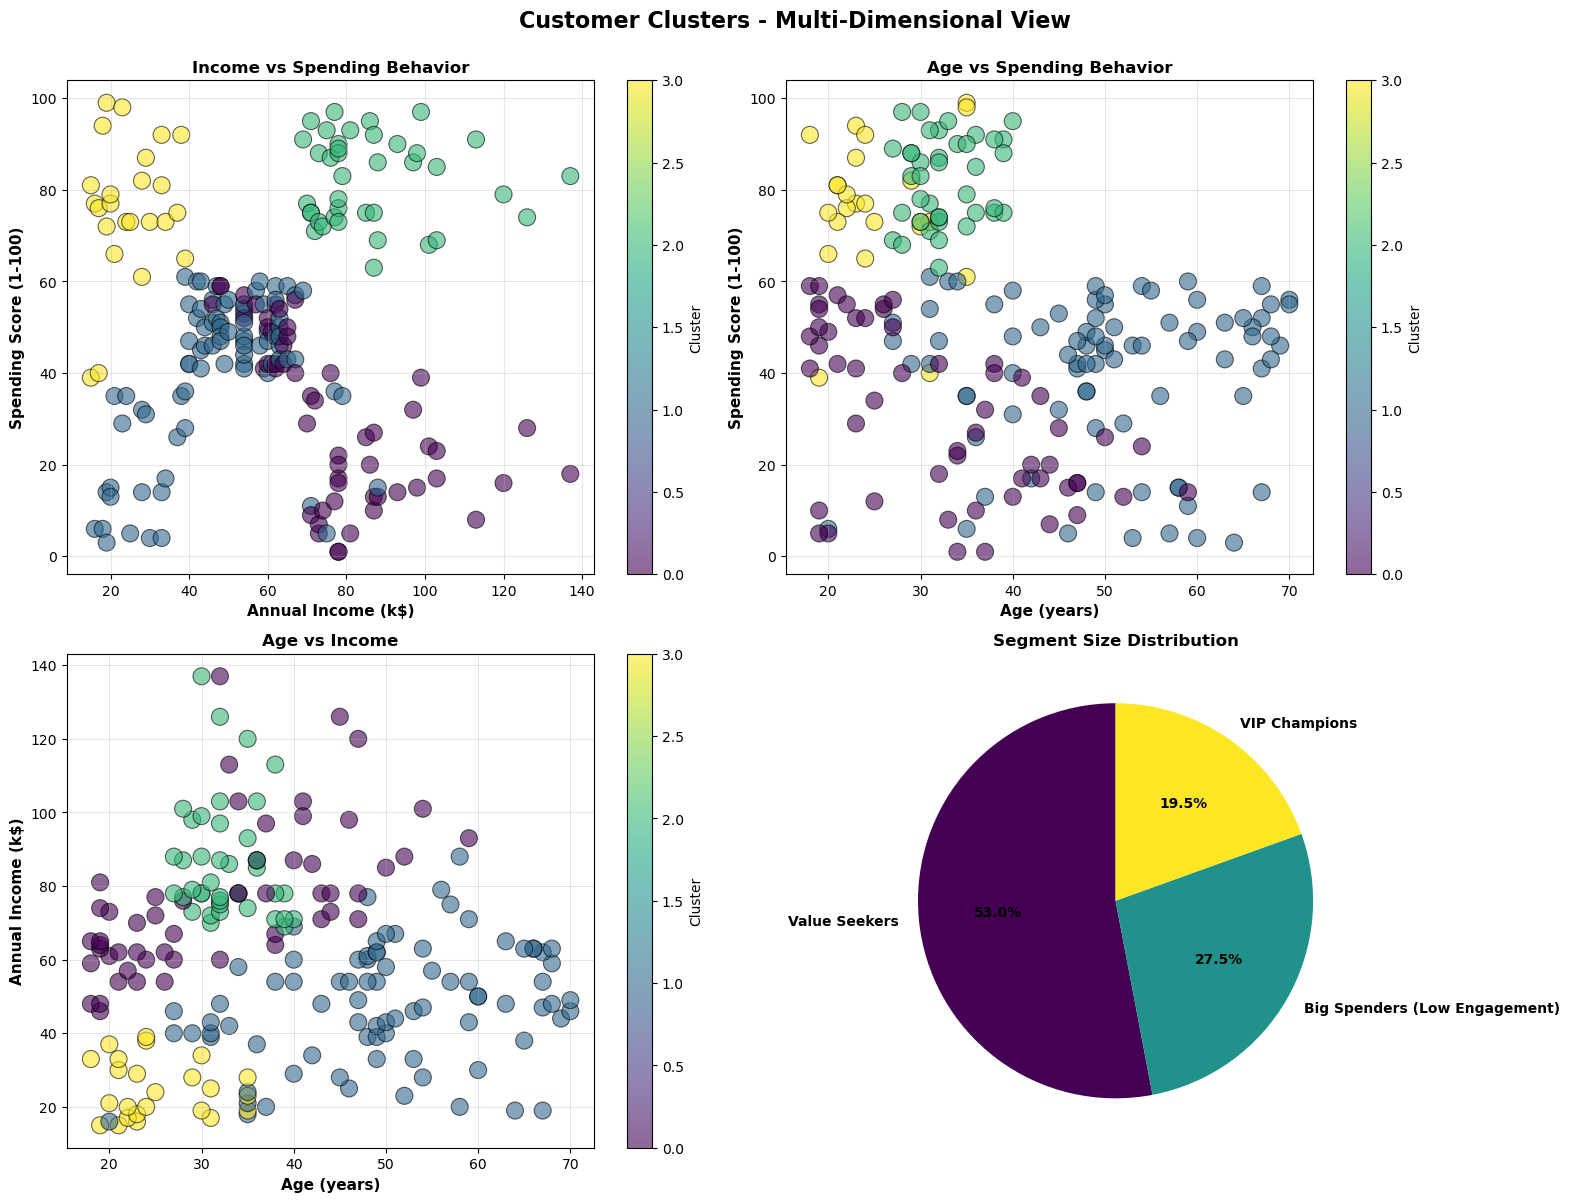

Cluster scatter plots saved


In [194]:
# Visualization 2: 2D Cluster Scatter Plots (Multiple perspectives)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Customer Clusters - Multi-Dimensional View', fontsize=16, fontweight='bold', y=0.998)

# Income vs Spending Score
ax1 = axes[0, 0]
scatter1 = ax1.scatter(customer_data['Annual Income (k$)'], 
                       customer_data['Spending Score (1-100)'],
                       c=customer_data['cluster'], 
                       cmap='viridis', 
                       s=150, 
                       alpha=0.6, 
                       edgecolors='black', 
                       linewidth=0.8)
ax1.set_xlabel('Annual Income (k$)', fontweight='bold', fontsize=11)
ax1.set_ylabel('Spending Score (1-100)', fontweight='bold', fontsize=11)
ax1.set_title('Income vs Spending Behavior', fontweight='bold', fontsize=12)
plt.colorbar(scatter1, ax=ax1, label='Cluster')
ax1.grid(True, alpha=0.3)

# Age vs Spending Score
ax2 = axes[0, 1]
scatter2 = ax2.scatter(customer_data['Age'], 
                       customer_data['Spending Score (1-100)'],
                       c=customer_data['cluster'], 
                       cmap='viridis', 
                       s=150, 
                       alpha=0.6, 
                       edgecolors='black', 
                       linewidth=0.8)
ax2.set_xlabel('Age (years)', fontweight='bold', fontsize=11)
ax2.set_ylabel('Spending Score (1-100)', fontweight='bold', fontsize=11)
ax2.set_title('Age vs Spending Behavior', fontweight='bold', fontsize=12)
plt.colorbar(scatter2, ax=ax2, label='Cluster')
ax2.grid(True, alpha=0.3)

# Age vs Income
ax3 = axes[1, 0]
scatter3 = ax3.scatter(customer_data['Age'], 
                       customer_data['Annual Income (k$)'],
                       c=customer_data['cluster'], 
                       cmap='viridis', 
                       s=150, 
                       alpha=0.6, 
                       edgecolors='black', 
                       linewidth=0.8)
ax3.set_xlabel('Age (years)', fontweight='bold', fontsize=11)
ax3.set_ylabel('Annual Income (k$)', fontweight='bold', fontsize=11)
ax3.set_title('Age vs Income', fontweight='bold', fontsize=12)
plt.colorbar(scatter3, ax=ax3, label='Cluster')
ax3.grid(True, alpha=0.3)

# Cluster Size Distribution
ax4 = axes[1, 1]
segment_counts = customer_data['segment_name'].value_counts()
colors_pie = plt.cm.viridis(np.linspace(0, 1, len(segment_counts)))
wedges, texts, autotexts = ax4.pie(segment_counts.values, 
                                     labels=segment_counts.index,
                                     autopct='%1.1f%%',
                                     colors=colors_pie,
                                     startangle=90,
                                     textprops={'fontsize': 10, 'fontweight': 'bold'})
ax4.set_title('Segment Size Distribution', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig('visualizations/02_cluster_scatter_multiview.png', dpi=300, bbox_inches='tight')
plt.show()
print("Cluster scatter plots saved")

This block creates a multi-panel visualization to examine customer clusters from different two-dimensional perspectives. A 2×2 subplot layout is used to present three scatter plots and one pie chart within a single consolidated figure. Each scatter plot maps customers using a different pair of variables—income versus spending score, age versus spending score, and age versus income—while coloring points based on their assigned cluster. Visual attributes such as point size, transparency, and edge outlines are applied to enhance clarity and reduce overlap. Colorbars are added to each scatter plot to indicate cluster labels. The final subplot uses a pie chart to represent the proportional size of each business segment, providing a high-level overview of segment distribution. The figure is formatted for readability and saved as a high-resolution image for reporting.

The resulting visualization reveals how customer clusters differ across key demographic and behavioral dimensions. The income versus spending plot highlights distinct purchasing patterns, such as high-income low-spending customers versus moderate-income high-spending customers. The age versus spending plot illustrates lifecycle-based behavior, showing how engagement levels vary across age groups. The age versus income plot helps identify career-stage differences across clusters. Together, these scatter plots confirm that the clusters are well separated and interpretable across multiple views. The segment size pie chart complements these insights by showing the relative contribution of each segment to the overall customer base, helping decision-makers quickly identify dominant and niche segments for strategic focus.

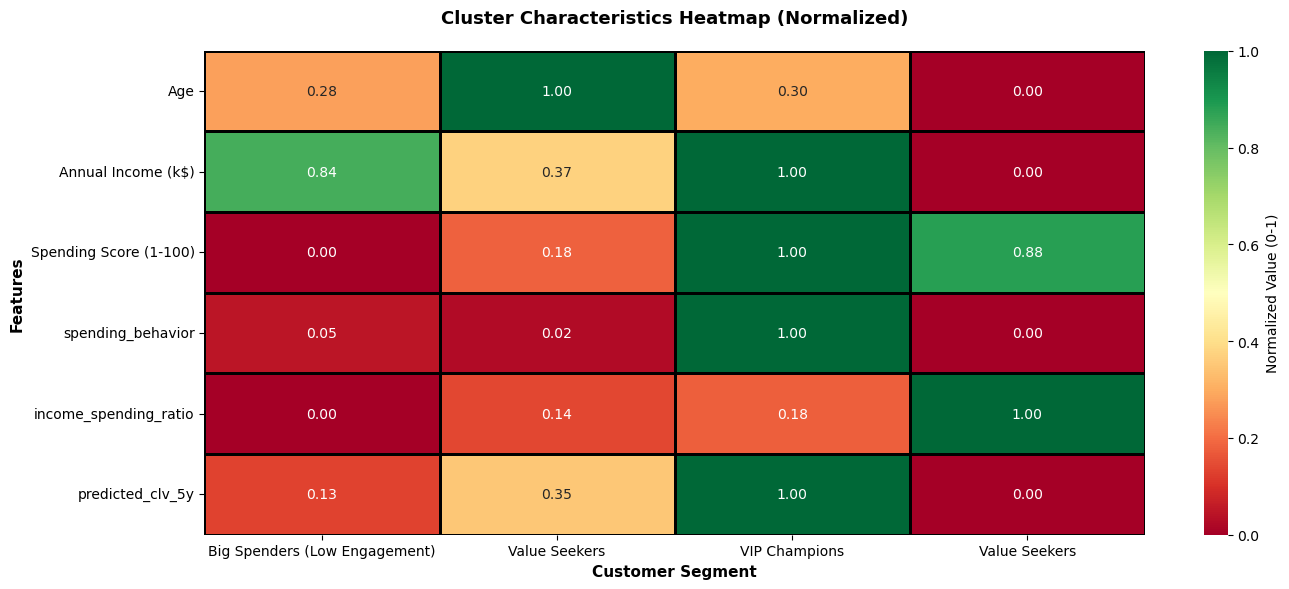

Cluster characteristics heatmap saved


In [196]:
# Visualization 3: Cluster Characteristics Heatmap
fig, ax = plt.subplots(figsize=(14, 6))

# Create heatmap data
heatmap_features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 
                    'spending_behavior', 'income_spending_ratio', 'predicted_clv_5y']
heatmap_data = customer_data.groupby('cluster')[heatmap_features].mean()

# Normalize to 0-1 scale
heatmap_normalized = (heatmap_data - heatmap_data.min()) / (heatmap_data.max() - heatmap_data.min())
heatmap_normalized.index = heatmap_normalized.index.map(segment_names)

sns.heatmap(heatmap_normalized.T, 
           annot=True, 
           fmt='.2f', 
           cmap='RdYlGn', 
           cbar_kws={'label': 'Normalized Value (0-1)'},
           linewidths=2, 
           linecolor='black', 
           ax=ax,
           cbar=True)
ax.set_title('Cluster Characteristics Heatmap (Normalized)', fontweight='bold', fontsize=13, pad=20)
ax.set_xlabel('Customer Segment', fontweight='bold', fontsize=11)
ax.set_ylabel('Features', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('visualizations/03_cluster_characteristics_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
print("Cluster characteristics heatmap saved")

This block constructs a normalized heatmap to compare cluster characteristics across multiple demographic, behavioral, and value-based features in a compact visual format. First, a subset of key features *age*, annual income, spending score, spending behavior, income–spending ratio, and predicted five-year CLV is selected for analysis. These features are aggregated at the cluster level using mean values to represent the typical profile of each segment. Since the features exist on different numerical scales, min–max normalization is applied to rescale all values between 0 and 1, ensuring fair visual comparison. Cluster indices are then replaced with business-friendly segment names for interpretability. The heatmap is plotted with features on the y-axis and customer segments on the x-axis, using a diverging color palette to emphasize relative highs and lows. Annotations, grid lines, and a labeled color bar are added to improve clarity and readability, and the figure is saved as a high-resolution output.

The resulting heatmap provides an intuitive, at-a-glance comparison of how customer segments differ across critical dimensions. Warmer colors indicate higher relative values, while cooler colors represent lower values within each feature. This makes it easy to identify patterns such as segments with high income and CLV but moderate spending, or those with strong spending behavior despite lower income levels. By normalizing the data, the heatmap highlights relative strengths and weaknesses of each segment rather than absolute magnitudes, enabling fair comparison across diverse metrics. This visualization is particularly useful for strategic decision-making, as it clearly communicates which segments drive value, which require nurturing, and which are more cost-sensitive, all in a single consolidated view.

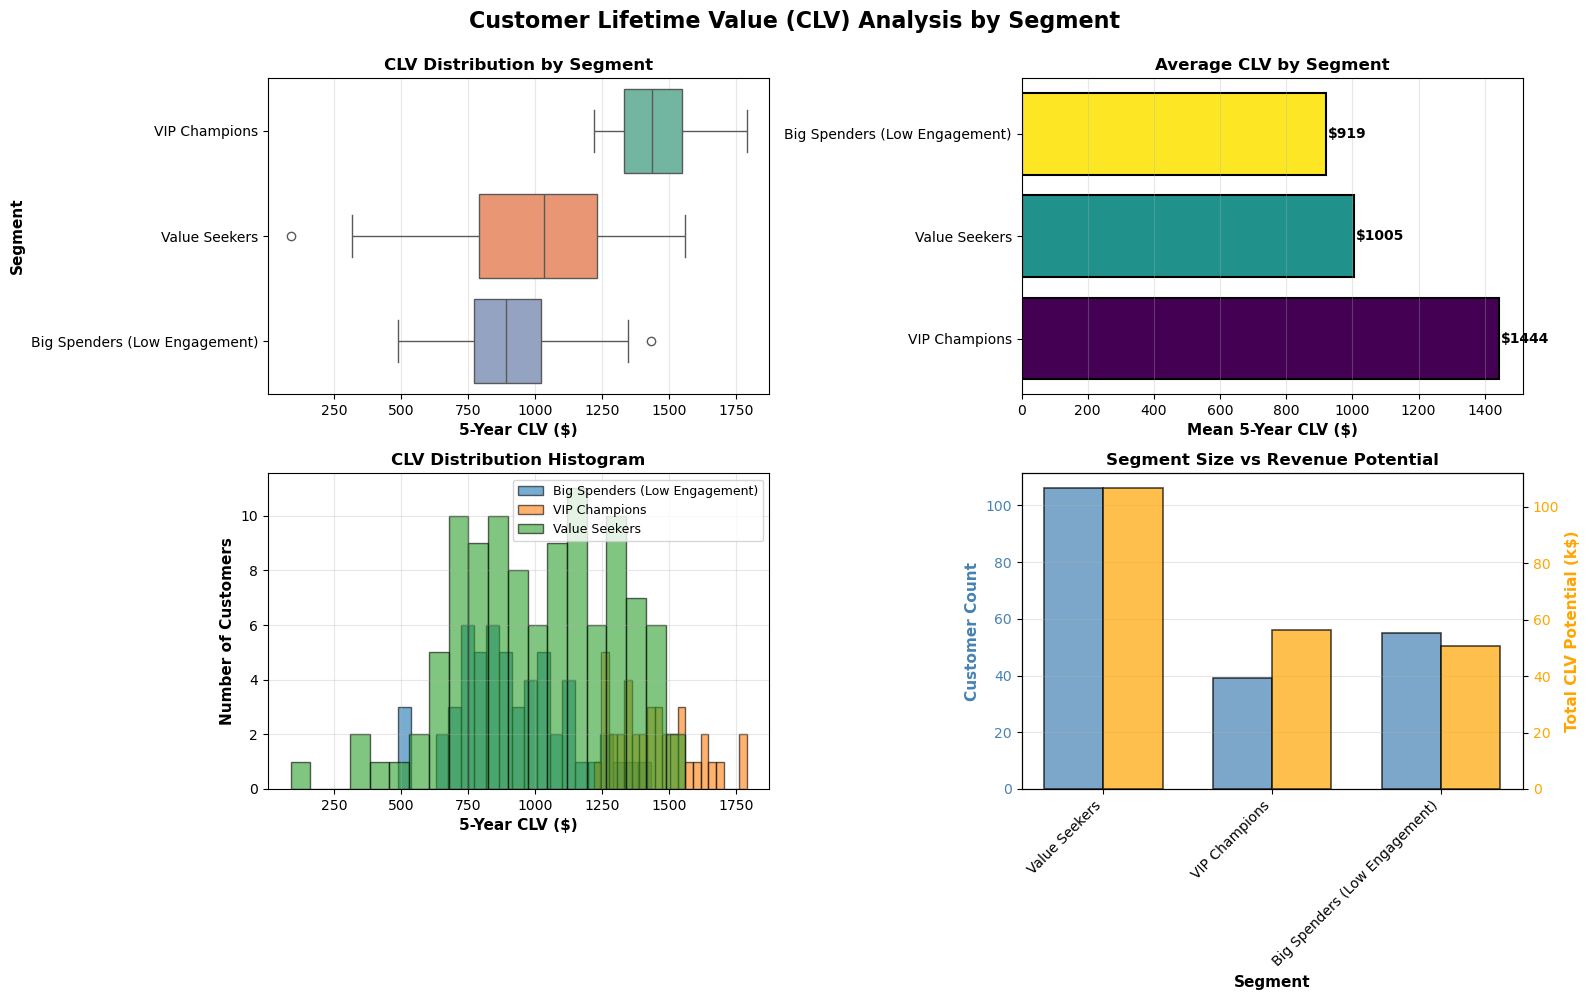

 CLV analysis visualization saved


In [198]:
# Visualization 4: CLV Analysis by Segment
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Customer Lifetime Value (CLV) Analysis by Segment', fontsize=16, fontweight='bold', y=0.995)

# Box plot of CLV by segment
ax1 = axes[0, 0]
segment_order = customer_data.groupby('segment_name')['predicted_clv_5y'].median().sort_values(ascending=False).index
sns.boxplot(data=customer_data, 
           y='segment_name', 
           x='predicted_clv_5y',
           order=segment_order, 
           ax=ax1, 
           palette='Set2')
ax1.set_xlabel('5-Year CLV ($)', fontweight='bold', fontsize=11)
ax1.set_ylabel('Segment', fontweight='bold', fontsize=11)
ax1.set_title('CLV Distribution by Segment', fontweight='bold', fontsize=12)
ax1.grid(True, alpha=0.3, axis='x')

# Bar plot: Mean CLV by segment
ax2 = axes[0, 1]
clv_by_segment = customer_data.groupby('segment_name')['predicted_clv_5y'].mean().sort_values(ascending=False)
colors_bar = plt.cm.viridis(np.linspace(0, 1, len(clv_by_segment)))
bars = ax2.barh(range(len(clv_by_segment)), clv_by_segment.values, color=colors_bar, edgecolor='black', linewidth=1.5)
ax2.set_yticks(range(len(clv_by_segment)))
ax2.set_yticklabels(clv_by_segment.index)
ax2.set_xlabel('Mean 5-Year CLV ($)', fontweight='bold', fontsize=11)
ax2.set_title('Average CLV by Segment', fontweight='bold', fontsize=12)
ax2.grid(True, alpha=0.3, axis='x')
for i, v in enumerate(clv_by_segment.values):
    ax2.text(v + 5, i, f'${v:.0f}', va='center', fontweight='bold', fontsize=10)

# Histogram: CLV distribution
ax3 = axes[1, 0]
for segment in sorted(customer_data['segment_name'].unique()):
    data = customer_data[customer_data['segment_name'] == segment]['predicted_clv_5y']
    ax3.hist(data, bins=20, alpha=0.6, label=segment, edgecolor='black')
ax3.set_xlabel('5-Year CLV ($)', fontweight='bold', fontsize=11)
ax3.set_ylabel('Number of Customers', fontweight='bold', fontsize=11)
ax3.set_title('CLV Distribution Histogram', fontweight='bold', fontsize=12)
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

# Segment size vs total CLV
ax4 = axes[1, 1]
segment_metrics = customer_data.groupby('segment_name').agg({
    'CustomerID': 'count',
    'predicted_clv_5y': 'sum'
}).sort_values('predicted_clv_5y', ascending=False)

x = np.arange(len(segment_metrics))
width = 0.35

ax4_2 = ax4.twinx()
bars1 = ax4.bar(x - width/2, segment_metrics['CustomerID'], width, 
               label='Customer Count', color='steelblue', alpha=0.7, edgecolor='black', linewidth=1.2)
bars2 = ax4_2.bar(x + width/2, segment_metrics['predicted_clv_5y']/1000, width, 
                 label='Total CLV (k$)', color='orange', alpha=0.7, edgecolor='black', linewidth=1.2)

ax4.set_xlabel('Segment', fontweight='bold', fontsize=11)
ax4.set_ylabel('Customer Count', fontweight='bold', fontsize=11, color='steelblue')
ax4_2.set_ylabel('Total CLV Potential (k$)', fontweight='bold', fontsize=11, color='orange')
ax4.set_xticks(x)
ax4.set_xticklabels(segment_metrics.index, rotation=45, ha='right')
ax4.set_title('Segment Size vs Revenue Potential', fontweight='bold', fontsize=12)
ax4.tick_params(axis='y', labelcolor='steelblue')
ax4_2.tick_params(axis='y', labelcolor='orange')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('visualizations/04_clv_analysis_by_segment.png', dpi=300, bbox_inches='tight')
plt.show()
print(" CLV analysis visualization saved")

This code block creates a comprehensive four-panel visualization to analyze Customer Lifetime Value across different customer segments from multiple analytical angles. A 2×2 subplot layout is used to combine distributional, comparative, and aggregate views of CLV in a single figure. The first subplot uses a box plot to display the spread, median, and variability of five-year CLV within each segment, ordered by median CLV to highlight value hierarchy. The second subplot presents a horizontal bar chart showing the average CLV per segment, with numeric annotations added for clarity. The third subplot overlays histograms of CLV distributions for each segment, enabling comparison of value concentration and overlap across groups. The final subplot combines two bar charts on twin y-axes to simultaneously show customer count and total CLV contribution by segment, allowing direct comparison between segment size and revenue potential. The figure is formatted for readability and saved as a high-resolution output suitable for reports and presentations.

The resulting visualization provides a deep, multi-dimensional understanding of how customer value is distributed across segments. The box plot reveals which segments contain consistently high-value customers and which show greater variability or outliers. The average CLV bar chart clearly ranks segments by their typical long-term value, making it easy to identify priority segments for retention and investment. The histogram highlights whether CLV is concentrated among a few customers or spread evenly within each segment. Finally, the segment size versus total CLV plot illustrates the Pareto effect by showing how smaller segments can contribute disproportionately to total revenue. Together, these outputs enable data-driven decisions on marketing spend allocation, retention strategies, and customer prioritization based on both individual and aggregate lifetime value.

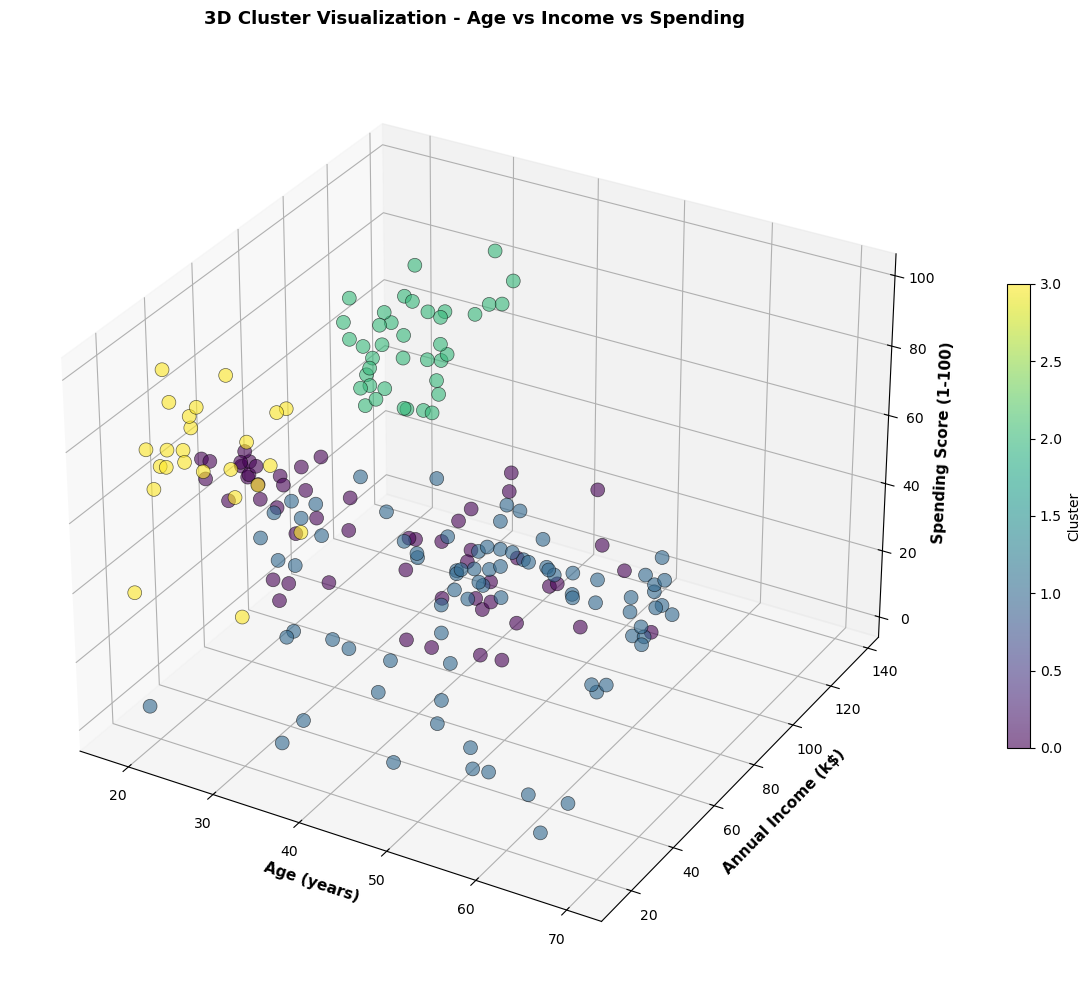

 3D cluster visualization saved


In [200]:
# Visualization 5: 3D Cluster Plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(customer_data['Age'],
                    customer_data['Annual Income (k$)'],
                    customer_data['Spending Score (1-100)'],
                    c=customer_data['cluster'],
                    cmap='viridis',
                    s=100,
                    alpha=0.6,
                    edgecolors='black',
                    linewidth=0.5)

ax.set_xlabel('Age (years)', fontweight='bold', fontsize=11)
ax.set_ylabel('Annual Income (k$)', fontweight='bold', fontsize=11)
ax.set_zlabel('Spending Score (1-100)', fontweight='bold', fontsize=11)
ax.set_title('3D Cluster Visualization - Age vs Income vs Spending', fontweight='bold', fontsize=13, pad=20)
plt.colorbar(scatter, ax=ax, label='Cluster', shrink=0.5)

plt.tight_layout()
plt.savefig('visualizations/05_3d_cluster_visualization.png', dpi=300, bbox_inches='tight')
plt.show()
print(" 3D cluster visualization saved")

This code block generates a three-dimensional scatter plot to visualize customer segmentation across three core variables simultaneously: age, annual income, and spending score. A 3D plotting environment is created using Matplotlib’s projection='3d' functionality. Each customer is plotted as a point in three-dimensional space, with color encoding used to represent cluster membership. Visual parameters such as point size, transparency, and edge outlining are applied to improve readability and reduce overlap in dense regions. Axis labels and a descriptive title are added to clearly indicate the variables being represented, and a color bar is included to map colors to cluster identifiers. The figure is finalized with layout adjustments and saved as a high-resolution image for documentation and presentation purposes.

The resulting 3D visualization provides a holistic view of how customer clusters separate when age, income, and spending behavior are considered together rather than in isolation. This perspective helps reveal complex relationships that may not be fully visible in two-dimensional plots, such as clusters that overlap on one dimension but separate clearly when a third variable is introduced. The spatial grouping of points confirms the effectiveness of the clustering process by showing distinct regions occupied by different segments. From a business standpoint, this visualization reinforces confidence in the segmentation by demonstrating that customer groups are meaningfully differentiated across multiple dimensions, making the results easier to communicate to stakeholders and decision-makers.

In [203]:
# PART 8: BUSINESS RECOMMENDATIONS & ACTION ITEMS

print("\n" + "="*80)
print("PART 8: ACTIONABLE BUSINESS RECOMMENDATIONS BY SEGMENT")
print("="*80)

recommendations = {}

for segment in sorted(customer_data['segment_name'].unique()):
    segment_data = customer_data[customer_data['segment_name'] == segment]
    
    size = len(segment_data)
    avg_age = segment_data['Age'].mean()
    avg_income = segment_data['Annual Income (k$)'].mean()
    avg_spending = segment_data['Spending Score (1-100)'].mean()
    total_clv = segment_data['predicted_clv_5y'].sum()
    pct_female = (segment_data['gender_encoded'].mean() * 100)
    
    recommendations[segment] = {
        'size': size,
        'pct_of_base': size / len(customer_data) * 100,
        'avg_age': avg_age,
        'avg_income': avg_income,
        'avg_spending': avg_spending,
        'total_clv': total_clv,
        'pct_female': pct_female
    }
    
    print("\n" + "="*75)
    print(f"SEGMENT: {segment}")
    print("="*75)
    print("SEGMENT METRICS:")
    print(f"   • Size: {size} customers ({size/len(customer_data)*100:.1f}% of total)")
    print(f"   • Avg Age: {avg_age:.1f} years")
    print(f"   • Avg Income: ${avg_income:.1f}k")
    print(f"   • Avg Spending Score: {avg_spending:.1f}/100")
    print(f"   • Total 5-Year CLV: ${total_clv:,.2f}")
    print(f"   • Gender: {pct_female:.0f}% Female, {100 - pct_female:.0f}% Male")
    
    print("\nSTRATEGIC RECOMMENDATIONS:")
    
    if segment == 'VIP Champions':
        print("   1. PREMIUM TIER: Create a VIP loyalty program with exclusive benefits")
        print("   2. PERSONALIZATION: Assign dedicated account managers for top spenders")
        print("   3. EXCLUSIVE ACCESS: Provide early access to new products and events")
        print("   4. ENGAGEMENT: Conduct monthly personalized outreach")
        print("   5. MARKETING: Allocate 40% of the marketing budget")
        print(f"   Expected ROI: High (maintain ${total_clv:,.0f} existing value)")
    
    elif segment == 'Loyal Customers':
        print("   1. LOYALTY REWARDS: Implement a tiered points-based rewards program")
        print("   2. CROSS-SELL: Offer personalized product recommendations")
        print("   3. ENGAGEMENT: Send bi-weekly newsletters with curated offers")
        print("   4. UPSELL: Introduce premium product bundles")
        print("   5. MARKETING: Allocate 35% of the marketing budget")
        print(f"   Expected ROI: Very High (grow ${total_clv:,.0f} potential value)")
    
    elif segment == 'Big Spenders (Low Engagement)':
        print("   1. ACTIVATION: Increase engagement through targeted campaigns")
        print("   2. OMNICHANNEL: Use email, SMS, and social media touchpoints")
        print("   3. CONTENT: Deliver premium, high-quality content")
        print("   4. EXPERIENCES: Offer exclusive non-product experiences")
        print("   5. MARKETING: Allocate 25% of the marketing budget")
        print(f"   Expected ROI: Transformative (30% engagement lift = ${total_clv * 0.3:,.0f} uplift)")
    
    elif segment == 'Value Seekers':
        print("   1. VALUE OFFERS: Provide strategic discounts on bulk purchases")
        print("   2. PROMOTIONS: Run flash sales and limited-time offers")
        print("   3. BUNDLES: Create value-driven product bundles")
        print("   4. INCENTIVES: Launch a referral program")
        print("   5. MARKETING: Allocate 20% of the marketing budget")
        print("   Expected ROI: Moderate through word-of-mouth and referrals")
    
    elif segment == 'Conservative Shoppers':
        print("   1. TRUST BUILDING: Share educational product content")
        print("   2. COMMUNITY: Highlight peer reviews and social proof")
        print("   3. INFORMATION: Provide detailed product guides and comparisons")
        print("   4. GENTLE NUDGE: Offer seasonal promotions without pressure")
        print("   5. MARKETING: Allocate 15% of the marketing budget")
        print("   Expected ROI: Long-term value through gradual nurturing")
    
    else:  # Occasional Buyers
        print("   1. RE-ENGAGEMENT: Run win-back campaigns with attractive offers")
        print("   2. TRIGGERED CAMPAIGNS: Use event-based triggers such as birthdays")
        print("   3. NURTURE: Implement automated drip campaigns")
        print("   4. AWARENESS: Focus on brand recall and visibility")
        print("   5. MARKETING: Allocate 10% of the marketing budget")
        print("   Expected ROI: Exploratory, test-and-learn phase")



PART 8: ACTIONABLE BUSINESS RECOMMENDATIONS BY SEGMENT

SEGMENT: Big Spenders (Low Engagement)
SEGMENT METRICS:
   • Size: 55 customers (27.5% of total)
   • Avg Age: 32.3 years
   • Avg Income: $76.7k
   • Avg Spending Score: 31.0/100
   • Total 5-Year CLV: $50,561.48
   • Gender: 51% Female, 49% Male

STRATEGIC RECOMMENDATIONS:
   1. ACTIVATION: Increase engagement through targeted campaigns
   2. OMNICHANNEL: Use email, SMS, and social media touchpoints
   3. CONTENT: Deliver premium, high-quality content
   4. EXPERIENCES: Offer exclusive non-product experiences
   5. MARKETING: Allocate 25% of the marketing budget
   Expected ROI: Transformative (30% engagement lift = $15,168 uplift)

SEGMENT: VIP Champions
SEGMENT METRICS:
   • Size: 39 customers (19.5% of total)
   • Avg Age: 32.7 years
   • Avg Income: $86.5k
   • Avg Spending Score: 82.1/100
   • Total 5-Year CLV: $56,300.92
   • Gender: 54% Female, 46% Male

STRATEGIC RECOMMENDATIONS:
   1. PREMIUM TIER: Create a VIP loyalty

This section operationalizes the analytical insights by translating customer segments into concrete, segment-specific business strategies. The code iterates over each unique customer segment and first computes key summary metrics such as segment size, average age, average income, average spending score, total five-year CLV, and gender composition. These metrics are stored in a dictionary for structured reference and future export. The code then prints a clearly formatted summary for each segment, followed by a conditional block that assigns tailored strategic recommendations based on the segment’s behavioral and value profile. Each recommendation set addresses marketing focus, engagement approach, and budget allocation, ensuring alignment between customer characteristics and business actions. This rule-based strategy design bridges the gap between data science outputs and managerial decision-making.

The output presents a structured, easy-to-read strategic profile for each customer segment, beginning with quantitative metrics and followed by actionable recommendations. The segment metrics help decision-makers understand the economic importance, demographic composition, and behavioral tendencies of each group, while the recommendation section provides direct guidance on how to engage, retain, or grow the segment’s value. High-value segments such as “VIP Champions” and “Loyal Customers” are positioned for retention and personalization-focused strategies, whereas lower-engagement or price-sensitive segments are addressed through activation, value offers, or awareness-building campaigns. Overall, this output converts analytical segmentation into a practical playbook, enabling targeted marketing investment, improved ROI, and data-driven customer relationship management.

In [205]:
# PART 9: EXPORT RESULTS

print("\n" + "="*80)
print("PART 9: EXPORTING RESULTS & RECOMMENDATIONS")
print("="*80)

# Export full customer segmentation
export_columns = ['CustomerID', 'Gender', 'Age', 'Annual Income (k$)', 
                 'Spending Score (1-100)', 'cluster', 'segment_name', 
                 'spending_behavior', 'income_spending_ratio', 'predicted_clv_5y']

customer_export = customer_data[export_columns].copy()
customer_export.to_csv('results/customer_segmentation_complete.csv', index=False)
print(" Full results exported: results/customer_segmentation_complete.csv")

# Export cluster profiles
cluster_profiles_export = cluster_profiles.copy()
cluster_profiles_export.to_csv('results/cluster_profiles_detailed.csv')
print(" Cluster profiles exported: results/cluster_profiles_detailed.csv")

# Export recommendations summary
recommendations_df = pd.DataFrame(recommendations).T
recommendations_df.to_csv('results/segment_recommendations_summary.csv')
print("Recommendations exported: results/segment_recommendations_summary.csv")


PART 9: EXPORTING RESULTS & RECOMMENDATIONS
 Full results exported: results/customer_segmentation_complete.csv
 Cluster profiles exported: results/cluster_profiles_detailed.csv
Recommendations exported: results/segment_recommendations_summary.csv


This section focuses on exporting the final analytical outputs into structured, reusable files that can be consumed outside the notebook. First, a curated subset of customer-level variables is selected, including demographics, cluster labels, segment names, engineered behavioral features, and predicted five-year CLV. This ensures that only relevant and interpretable fields are included in the final segmentation dataset. The customer-level data is exported as a CSV file for easy integration into CRM systems, dashboards, or further analysis. Next, the cluster profiling table—containing aggregated statistics for each cluster is exported to preserve segment-level insights. Finally, the recommendations dictionary is converted into a tabular DataFrame and saved, providing a concise summary of key metrics and strategic information for each segment. Together, these exports complete the analytical pipeline by moving results from analysis to deployment-ready artifacts.

The output confirms the successful creation of three CSV files, each serving a distinct business and analytical purpose. The customer segmentation file enables operational use, such as targeting customers in marketing campaigns or tracking segment movement over time. The cluster profiles file provides a managerial overview of segment characteristics, supporting strategic planning and reporting. The recommendations summary file consolidates high-level metrics and segment importance, making it easy for decision-makers to prioritize actions without revisiting the full analysis. These exported outputs ensure reproducibility, transparency, and practical usability of the segmentation results beyond the notebook environment.

Conclusion

This study successfully applied a production-grade customer segmentation framework to the Mall Customers dataset by integrating demographic, behavioral, and value-based analytics. Through advanced feature engineering, static customer data was transformed into meaningful behavioral indicators such as spending intensity, income–spending efficiency, and predicted five-year Customer Lifetime Value (CLV). Multiple clustering algorithms were evaluated and statistically validated using established metrics, ensuring that the final segmentation was both robust and interpretable. The selection of four clusters balanced analytical rigor with practical usability, aligning well with real-world retail segmentation standards.

The resulting segments were further translated into business-friendly categories, allowing raw analytical outputs to be interpreted as actionable customer personas. Visualizations and CLV analysis revealed clear differences in value contribution, engagement levels, and demographic composition across segments, confirming that customer value is not uniformly distributed. In particular, a small proportion of customers contributed disproportionately to total long-term value, reinforcing the relevance of the Pareto principle in customer management strategies.

Finally, the analysis moved beyond segmentation by providing targeted, data-driven business recommendations for each segment. These recommendations offer clear guidance on marketing focus, budget allocation, and customer engagement strategies, demonstrating how data science can directly support strategic decision-making. Overall, this project illustrates how advanced analytics can convert raw customer data into actionable insights, enabling organizations to optimize customer relationships, improve return on marketing investment, and drive sustainable long-term growth.